In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [ ]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('liver-tumor-segmentation'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        file_list.append((dirname,filename))

for dirname, _, filenames in os.walk('liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname,filename))

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename'])
df_files.sort_values(by=['filename'], ascending=True)

,dirname,filename
89,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-0.nii
81,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-1.nii
142,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-10.nii
31,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-100.nii
45,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...
243,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii
222,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii
217,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii
252,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii


In [ ]:
# Map CT scan and label

df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"

    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "liver-tumor-segmentation/segmentations"

df_files_test= df_files[df_files.mask_filename=='']
# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True)
print(len(df_files))
df_files
#df_files_test

131


,dirname,filename,mask_dirname,mask_filename
0,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-100.nii,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-101.nii,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...,...,...
126,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii,../input/liver-tumor-segmentation/segmentations,segmentation-95.nii
127,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii,../input/liver-tumor-segmentation/segmentations,segmentation-96.nii
128,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii,../input/liver-tumor-segmentation/segmentations,segmentation-97.nii
129,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii,../input/liver-tumor-segmentation/segmentations,segmentation-98.nii


In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [ ]:
# Read sample
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
print(sample_ct.shape)
print(sample_mask.shape)
print(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])

(512, 512, 75)
(512, 512, 75)
/kaggle/input/liver-tumor-segmentation/volume_pt1/volume-0.nii


In [ ]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


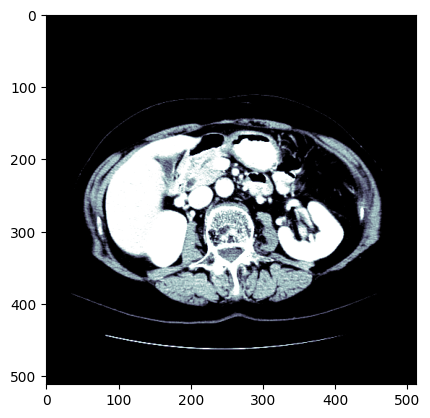

In [ ]:
# Preprocess the nii file
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')

    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

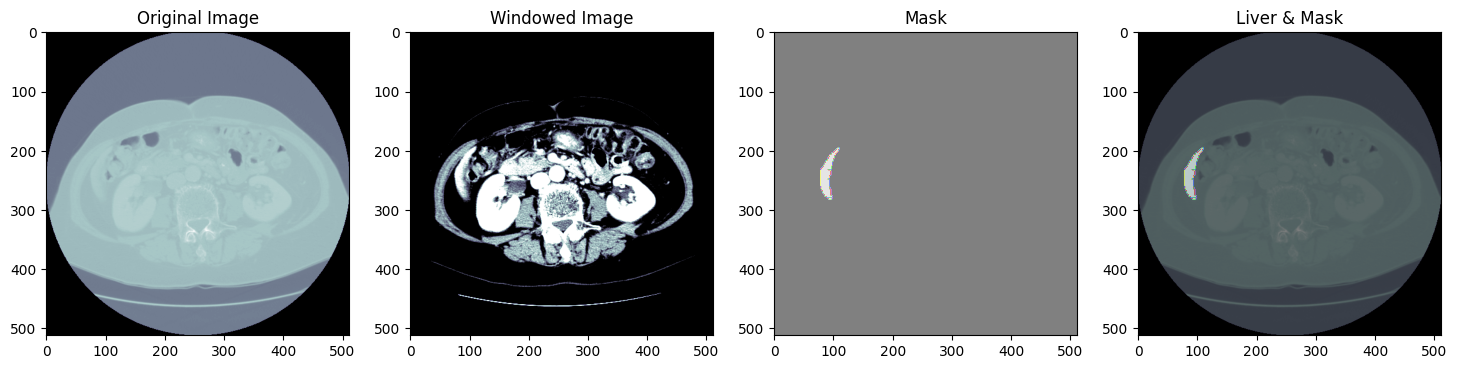

In [ ]:
sample=45
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [ ]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 261034]
 [     1   1110]]


<Axes: >

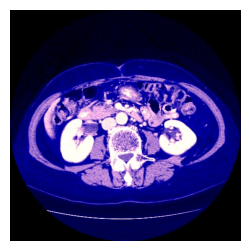

In [ ]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    ''''"A function to split the range of pixel values into groups,
    such that each group has around the same number of pixels"'''
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)


@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])

In [ ]:
df_files_1=df_files[0:30]
df_files_1

,dirname,filename,mask_dirname,mask_filename
0,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-100.nii,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-101.nii,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
5,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-102.nii,../input/liver-tumor-segmentation/segmentations,segmentation-102.nii
6,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-103.nii,../input/liver-tumor-segmentation/segmentations,segmentation-103.nii
7,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-104.nii,../input/liver-tumor-segmentation/segmentations,segmentation-104.nii
8,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-105.nii,../input/liver-tumor-segmentation/segmentations,segmentation-105.nii
9,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-106.nii,../input/liver-tumor-segmentation/segmentations,segmentation-106.nii


In [ ]:
import random

GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h

if GENERATE_JPG_FILES:
    path = Path(".")

    os.makedirs('train_images', exist_ok=True)
    os.makedirs('train_masks', exist_ok=True)

    # Randomly select 1/3 of the indices
    random_indices = random.sample(range(len(df_files)), len(df_files) // 2)

    for ii in tqdm(random_indices):  # take 1/3 nii files for training
        curr_ct = read_nii(df_files.loc[ii, 'dirname'] + "/" + df_files.loc[ii, 'filename'])
        curr_mask = read_nii(df_files.loc[ii, 'mask_dirname'] + "/" + df_files.loc[ii, 'mask_filename'])
        curr_file_name = str(df_files.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]  # 512, 512, curr_dim

        for curr_slice in range(0, curr_dim, 2):  # export every 2nd slice for training
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    path = Path("../input/liver-segmentation-with-fastai-v2")  # read jpg from saved kernel output


  0%|          | 0/65 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.model_selection import train_test_split

# Set the directories
images_dir = 'train_images'
masks_dir = 'train_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(images_dir))

# Randomly select 9000 images
selected_image_file_names = random.sample(all_image_file_names, 9000)

# Load selected images and masks with resizing
target_size = (128, 128)
images = [np.array(Image.open(os.path.join(images_dir, fname)).resize(target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
masks = [np.array(Image.open(os.path.join(masks_dir, fname)).resize(target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Normalize images to [0, 1]
images = images / 255.0

# Reshape masks to include a channel dimension
masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], 1))


In [ ]:
# Split the data into training, validation, and test sets
# 70% training, 20% validation, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)

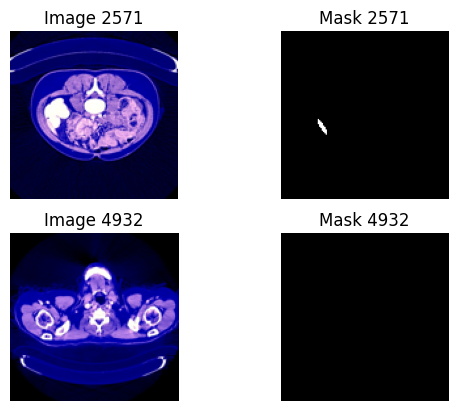

In [ ]:
import matplotlib.pyplot as plt

# Function to display images and masks
def display_images_and_masks(images, masks, num_samples=2):
    # Randomly select samples
    sample_indices = random.sample(range(images.shape[0]), num_samples)

    for i in range(num_samples):
        index = sample_indices[i]

        # Display the image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[index])
        plt.title("Image {}".format(index))
        plt.axis("off")

        # Display the mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[index].squeeze(), cmap='gray')
        plt.title("Mask {}".format(index))
        plt.axis("off")

    plt.show()

# Display two random images and masks
display_images_and_masks(x_train, y_train)

In [ ]:
y_train.shape, x_train.shape

((6300, 128, 128, 1), (6300, 128, 128, 3))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def create_fcn_model(input_shape=(128, 128, 3), target_shape=(128, 128, 1)):
    model = keras.Sequential()

    # Encoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Decoder with Skip Connections
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    # Output layer
    model.add(layers.Conv2D(1, (1, 1), activation='sigmoid'))  # Assuming binary classification

    # Crop to match the target shape
    crop_height = (model.output_shape[1] - target_shape[0]) // 2
    crop_width = (model.output_shape[2] - target_shape[1]) // 2
    model.add(layers.Cropping2D(cropping=((crop_height, crop_height), (crop_width, crop_width))))

    return model
# Create the FCN model
model = create_fcn_model()

# Display the model summary
model.summary()
model.save('fcn_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                        

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred):
    smooth = 1.0  # Smoothing factor to avoid division by zero
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpoint = tf.keras.callbacks.ModelCheckpoint("fcn_model.h5", monitor='val_loss', verbose=1, patience = 3,save_best_only=True,
                                                save_weights_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

In [ ]:
from tensorflow.keras.optimizers import Adam
# Compile the model [0.001,0001, 6e-e]
model.compile(optimizer=Adam(lr=.001),loss='binary_crossentropy',
              metrics=[dice_coefficient])

In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[reduce_lr,checkpoint])
model.save('fcn_model2.h5')

Epoch 1/5
394/394 [==============================] - ETA: 0s - loss: 0.2145 - dice_coefficient: 0.2475
Epoch 1: val_loss improved from inf to 0.09997, saving model to fcn_model.h5
394/394 [==============================] - 1796s 5s/step - loss: 0.2145 - dice_coefficient: 0.2475 - val_loss: 0.1000 - val_dice_coefficient: 0.0757 - lr: 0.0010
Epoch 2/5
394/394 [==============================] - ETA: 0s - loss: 0.0352 - dice_coefficient: 0.5761
Epoch 2: val_loss improved from 0.09997 to 0.06255, saving model to fcn_model.h5
394/394 [==============================] - 1778s 5s/step - loss: 0.0352 - dice_coefficient: 0.5761 - val_loss: 0.0626 - val_dice_coefficient: 0.4449 - lr: 0.0010
Epoch 3/5
394/394 [==============================] - ETA: 0s - loss: 0.0186 - dice_coefficient: 0.7167
Epoch 3: val_loss improved from 0.06255 to 0.02141, saving model to fcn_model.h5
394/394 [==============================] - 1771s 4s/step - loss: 0.0186 - dice_coefficient: 0.7167 - val_loss: 0.0214 - val_dice

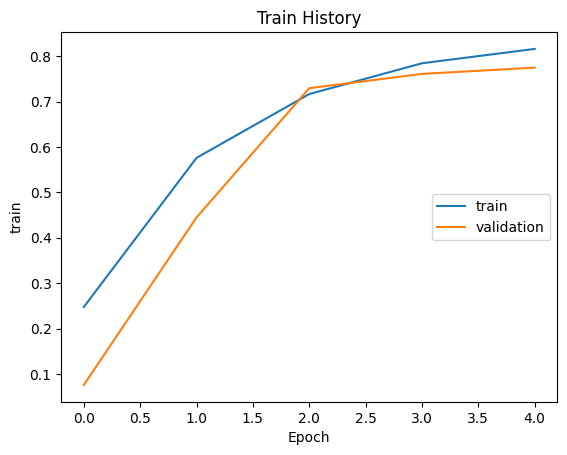

In [ ]:
import matplotlib.pyplot as plt
def show_history(history, train, validation):
    plt.plot(history.history[train])
    plt.plot(history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()
show_history(history, 'dice_coefficient', 'val_dice_coefficient')

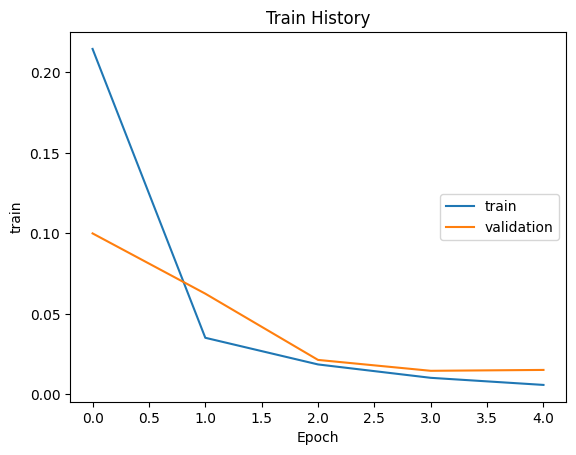

In [ ]:
show_history(history, 'loss', 'val_loss')

In [ ]:
scores = model.evaluate(x_valid, y_valid)
scores[1]

57/57 [==============================] - 136s 2s/step - loss: 0.0152 - dice_coefficient: 0.7932


0.7931864261627197

In [ ]:
prediction = model.predict(x_test)
print(prediction)
# print(y_test)

29/29 [==============================] - 69s 2s/step
[[[[0.00192067]
   [0.00099506]
   [0.00093165]
   ...
   [0.00097535]
   [0.00099847]
   [0.00124808]]

  [[0.00092983]
   [0.00069457]
   [0.00061164]
   ...
   [0.00067711]
   [0.00066283]
   [0.00092983]]

  [[0.00093208]
   [0.00068384]
   [0.00064097]
   ...
   [0.00077988]
   [0.00069796]
   [0.00098466]]

  ...

  [[0.00095738]
   [0.00072727]
   [0.00070688]
   ...
   [0.00091438]
   [0.00090529]
   [0.00129912]]

  [[0.00111026]
   [0.0007879 ]
   [0.00071969]
   ...
   [0.00088302]
   [0.00090732]
   [0.00128095]]

  [[0.0011211 ]
   [0.00097051]
   [0.00097296]
   ...
   [0.00106481]
   [0.00109661]
   [0.00151111]]]


 [[[0.00185819]
   [0.00142234]
   [0.00113963]
   ...
   [0.00124232]
   [0.00144125]
   [0.0015531 ]]

  [[0.00120916]
   [0.00096584]
   [0.00073778]
   ...
   [0.00087042]
   [0.00127618]
   [0.00172345]]

  [[0.00117097]
   [0.00091251]
   [0.00082303]
   ...
   [0.00070025]
   [0.00100091]
   [0.00143

In [ ]:
test_scores = model.evaluate(x_test, y_test)
test_scores[1]

29/29 [==============================] - 68s 2s/step - loss: 0.0174 - dice_coefficient: 0.7997


0.7996634840965271

1/1 [==============================] - 0s 91ms/step


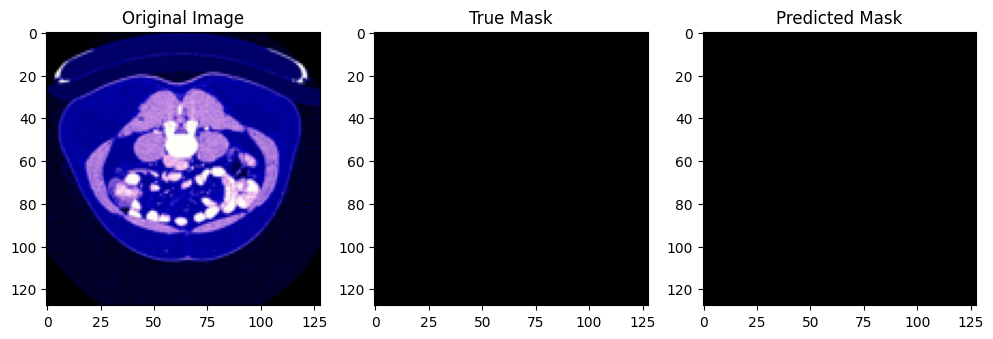

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have x_test and y_test
# Replace this with the actual index of the image you want to visualize
image_index = 47

# Load the image and true mask
input_image = x_test[image_index]
true_mask = y_test[image_index]

# Obtain the predicted mask from model2
predicted_mask = model.predict(np.expand_dims(input_image, axis=0))[0]

# Threshold the predicted mask (assuming it's a binary mask)
threshold = 0.5  # Adjust this threshold based on your model's output
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()
